In [ ]:

from utils.check_image import check_image
import nibabel as nib

image = nib.load(f"data/nnunet_raw/Dataset001_raw_aaa/imagesTs/aaa_020_0000.nii.gz").get_fdata()
ground_truth = nib.load(f"data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_020.nii.gz").get_fdata()
label0 = nib.load(f"data/nnunet_raw/Dataset002_origin_synthseg/outputTs/aaa_020.nii.gz").get_fdata()
label1 = nib.load(f"data/nnunet_raw/Dataset003_perlin_synthseg/outputTs/aaa_020.nii.gz").get_fdata()
label2 = nib.load(f"data/nnunet_raw/Dataset004_perlin_synthseg/outputTs/aaa_020.nii.gz").get_fdata()

check_image(
    [
        {"image": image, "title": "Image", "is_label": False},
        {"image": ground_truth, "title": "Manual label", "is_label": True},
        {"image": label0, "title": "Improved SynthSeg", "is_label": True},
        {"image": label1, "title": "Original Synthseg", "is_label": True},
        {"image": label2, "title": "Perlin Synthseg", "is_label": True},
    ]
)


interactive(children=(IntSlider(value=0, description='slice_index_0', max=116), IntSlider(value=0, description…

In [2]:
nib.load(f"data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_020.nii.gz").get_fdata()

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [1]:

from utils.nrrd2nii import nrrd2nii
from utils.check_image import check_image
import nibabel as nib


image = nrrd2nii("data/uwa_aaa/Patient22/Segmentation/Patient 22 Crop.nrrd").get_fdata()
label0 = nrrd2nii(f"data/uwa_aaa/Patient22/Segmentation/ILT22.seg.nrrd").get_fdata()
label1 = nrrd2nii(f"data/uwa_aaa/Patient22/Segmentation/Lumen.seg.nrrd").get_fdata()
check_image(
    [
        {"image": image, "title": "image", "is_label": False},
        # {"image": ground_truth, "title": "label", "is_label": True},
        {"image": label0, "title": "label", "is_label": True},
        {"image": label1, "title": "label", "is_label": True},
    ]
)


interactive(children=(IntSlider(value=0, description='slice_index_0', max=333), IntSlider(value=0, description…

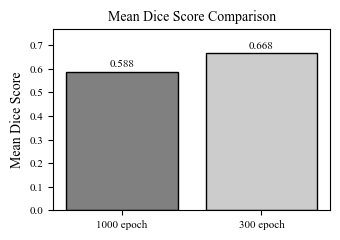

In [5]:
import nibabel as nib
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set IEEE style: Times New Roman or similar serif font
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 10  # Base font size for text
plt.rcParams['axes.labelsize'] = 10  # Axis labels
plt.rcParams['axes.titlesize'] = 10  # Title
plt.rcParams['xtick.labelsize'] = 8  # Tick labels
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 8
plt.rcParams['figure.figsize'] = (3.5, 2.5)  # IEEE single-column figure width in inches
plt.rcParams['axes.grid'] = False  # Explicitly disable grid

def load_and_pad_label(file_path, reference_shape):
    """Load a NIfTI file and pad it to ensure even dimensions."""
    label = nib.load(file_path).get_fdata()
    padding = [(0, 1 if dim % 2 == 1 else 0) for dim in label.shape]
    label = np.pad(label, padding, mode="constant")
    return label

def calculate_dice_score(pred, target):
    """Calculate Dice score for a single class between prediction and target."""
    pred = torch.from_numpy(pred).float().flatten()
    target = torch.from_numpy(target).float().flatten()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2. * intersection) / (union + 1e-8)  # Small epsilon to avoid division by zero
    return dice.item()

def compute_dice_scores(label, ground_truth):
    """Compute Dice scores for all classes (excluding background)."""
    num_classes = int(max(label.max(), ground_truth.max())) + 1
    dice_scores = []
    for class_id in range(1, num_classes):  # Skip background class (0)
        pred_class = (label == class_id).astype(int)
        target_class = (ground_truth == class_id).astype(int)
        dice_score = calculate_dice_score(pred_class, target_class)
        dice_scores.append(dice_score)
    return dice_scores

# Define IDs to process
ids = [f"{i:03d}" for i in range(16, 21)]  # 016 to 020
all_dice_raw = []
all_dice_perlin = []
all_dice_synthseg = []

# Process each ID
for id in ids:
    # File paths
    ground_truth_path = f"data/nnunet_raw/Dataset001_raw_aaa/labelsTs/aaa_{id}.nii.gz"
    label_raw_path = f"data/nnunet_raw/Dataset001_raw_aaa/outputTs/aaa_{id}.nii.gz"
    label_perlin_path = f"data/nnunet_raw/Dataset003_perlin_synthseg/outputTs/aaa_{id}.nii.gz"
    label_synthseg_path = f"data/nnunet_raw/Dataset004_perlin_synthseg/outputTs/aaa_{id}.nii.gz"

    # Load data
    ground_truth = nib.load(ground_truth_path).get_fdata()
    label_raw = load_and_pad_label(label_raw_path, ground_truth.shape)
    label_perlin = load_and_pad_label(label_perlin_path, ground_truth.shape)
    label_synthseg = load_and_pad_label(label_synthseg_path, ground_truth.shape)

    # Compute Dice scores
    all_dice_raw.extend(compute_dice_scores(label_raw, ground_truth))
    all_dice_perlin.extend(compute_dice_scores(label_perlin, ground_truth))
    all_dice_synthseg.extend(compute_dice_scores(label_synthseg, ground_truth))

# Calculate mean Dice scores
mean_dice_raw = np.mean(all_dice_raw) if all_dice_raw else 0
mean_dice_perlin = np.mean(all_dice_perlin) if all_dice_perlin else 0
mean_dice_synthseg = np.mean(all_dice_synthseg) if all_dice_synthseg else 0

# Generate bar chart
fig, ax = plt.subplots()
labels = ['1000 epoch', '300 epoch']
mean_scores = [mean_dice_perlin, mean_dice_synthseg]
colors = ['0.5', '0.8']  # Grayscale for IEEE print compatibility

bars = ax.bar(labels, mean_scores, color=colors, edgecolor='black')
ax.set_ylabel('Mean Dice Score')
ax.set_title('Mean Dice Score Comparison')

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.3f}', 
            ha='center', va='bottom', fontsize=8)

# Set y-axis limit with padding to avoid overlap
ax.set_ylim(0, max(mean_scores) + 0.1)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save plot
plt.savefig('mean_dice_score_comparison.png', dpi=300, bbox_inches='tight')